In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import re
import string




In [3]:
df_fake = pd.read_csv('ML KNN Overview Fake.txt', header=None)
df_real = pd.read_csv('ML KNN Overview Real.txt', header=None)

# Đặt tên cột là 'title'
df_fake.columns = ['title']
df_real.columns = ['title']

# Hiển thị 5 hàng đầu tiên của DataFrame
print(df_fake.head())
print(df_real.head())


                                               title
0           trump warns of vote flipping on machines
1  this election is not about trump its about a g...
2  more on trump populism and how it can be contr...
3  trump bollywood ad meant to sway indian americ...
4  dems could be up on charges for inciting trump...
                                               title
0  donald trump do you remember the year since he...
1  trump defends son over emails as moscow hits back
2  donald trump strategist says media wont easily...
3  anthony scaramucci who is donald trumps new co...
4  donald trumps mobile phone use worries securit...


### Inserting a column "class" as target feature

In [4]:
df_fake['class']=0
df_real['class']=1

In [5]:
df_fake.shape,df_real.shape

((1298, 2), (1968, 2))

In [6]:
# Combine fake and real data
df = pd.concat([df_fake, df_real])
X = df['title']
y = df['class']


In [7]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\d+', '', text)  # Remove digits
    return text

X = X.apply(preprocess_text)

In [8]:
df


,title,class
0,trump warns of vote flipping on machines,0
1,this election is not about trump its about a g...,0
2,more on trump populism and how it can be contr...,0
3,trump bollywood ad meant to sway indian americ...,0
4,dems could be up on charges for inciting trump...,0
...,...,...
1963,donald trump tells guam north korean threat a ...,1
1964,abc news quiz trump golden globes,1
1965,cancel it trump says new air force one cost ri...,1
1966,trump trade policies easier said than done,1


## Split the data set

In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [10]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Oversampling

Shape of training data before oversampling: (2612, 5000) 




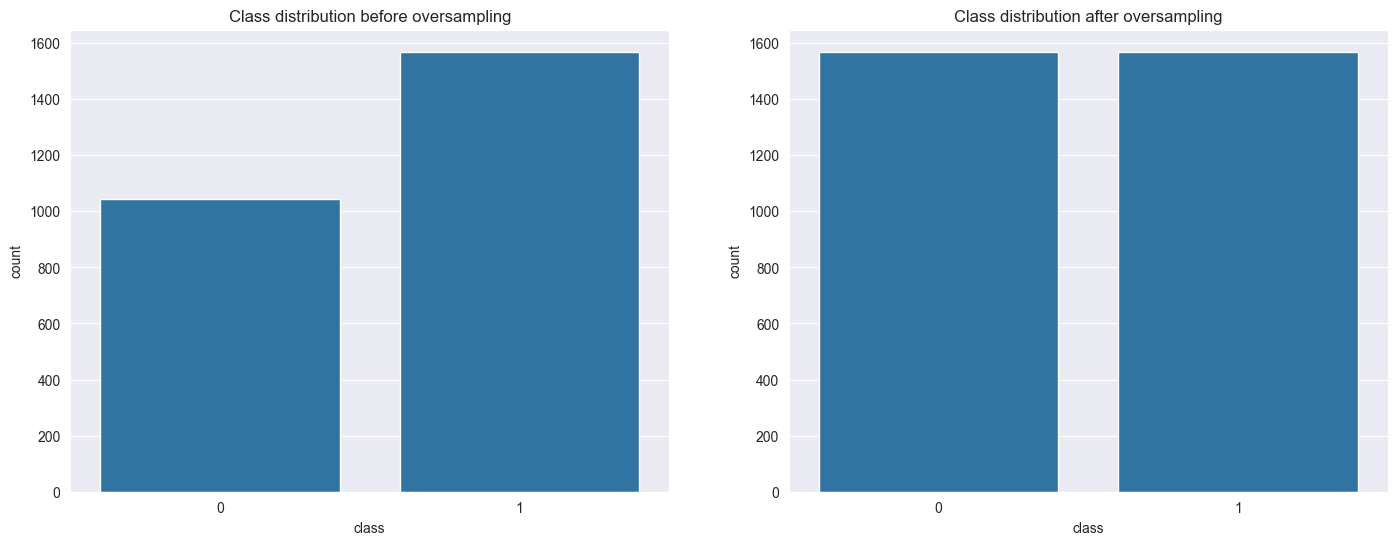

Shape of training data after oversampling: (3138, 5000)


In [11]:
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

# Visualize class imbalance before oversampling
plt.figure(1, figsize=(17, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Class distribution before oversampling')
print('Shape of training data before oversampling:', X_train_tfidf.shape, '\n\n')
# Perform oversampling using RandomOverSampler
ros = RandomOverSampler()
X_train_tfidf_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)

# Visualize class distribution after oversampling
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_res)
plt.title('Class distribution after oversampling')
plt.show()
print('Shape of training data after oversampling:', X_train_tfidf_res.shape)



### Training model with LogisticRegression

In [12]:
model=LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf_res, y_train_res)

LogisticRegression(max_iter=1000)

In [13]:
y_pred=model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

In [14]:

print(f'Accuracy: {accuracy * 100:.2f}%')
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
class_report = classification_report(y_test, y_pred)
print(class_report)


Accuracy: 82.26%
[[203  52]
 [ 64 335]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       255
           1       0.87      0.84      0.85       399

    accuracy                           0.82       654
   macro avg       0.81      0.82      0.82       654
weighted avg       0.82      0.82      0.82       654



## Descision Tree


In [15]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(X_train_tfidf_res, y_train_res)


DecisionTreeClassifier()

In [16]:
pred_dt = DT.predict(X_test_tfidf)


In [17]:
DT.score(X_test_tfidf, y_test)


0.7048929663608563

In [18]:
print(classification_report(y_test, pred_dt))


              precision    recall  f1-score   support

           0       0.63      0.58      0.61       255
           1       0.75      0.78      0.76       399

    accuracy                           0.70       654
   macro avg       0.69      0.68      0.68       654
weighted avg       0.70      0.70      0.70       654



In [19]:
KNN= KNeighborsClassifier()
KNN.fit(X_train_tfidf_res,y_train_res)


KNeighborsClassifier()

In [20]:
pred_kn=KNN.predict(X_test_tfidf)
KNN.score(X_test_tfidf, y_test)


0.7706422018348624

In [21]:
print(classification_report(y_test, pred_kn))


              precision    recall  f1-score   support

           0       0.75      0.62      0.68       255
           1       0.78      0.87      0.82       399

    accuracy                           0.77       654
   macro avg       0.76      0.74      0.75       654
weighted avg       0.77      0.77      0.77       654



### Gradient Boosting Classifier¶


In [22]:
from sklearn.ensemble import AdaBoostClassifier

ADC = AdaBoostClassifier(random_state=20)
ADC.fit(X_train_tfidf_res, y_train_res)

/Library/Python/3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=20)

In [23]:
pred_adc = ADC.predict(X_test_tfidf)

ADC.score(X_test_tfidf, y_test)

0.7568807339449541

In [24]:
print(classification_report(y_test, pred_adc))


              precision    recall  f1-score   support

           0       0.74      0.58      0.65       255
           1       0.77      0.87      0.81       399

    accuracy                           0.76       654
   macro avg       0.75      0.73      0.73       654
weighted avg       0.75      0.76      0.75       654



In [25]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=20)
RFC.fit(X_train_tfidf_res, y_train_res)
pred_rfc = RFC.predict(X_test_tfidf)

RFC.score(X_test_tfidf, y_test)


0.7859327217125383

In [26]:
print(classification_report(y_test, pred_rfc))


              precision    recall  f1-score   support

           0       0.76      0.65      0.70       255
           1       0.80      0.87      0.83       399

    accuracy                           0.79       654
   macro avg       0.78      0.76      0.77       654
weighted avg       0.78      0.79      0.78       654



## Model Testing


In [27]:

def output_label(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"

def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(preprocess_text)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorizer.transform(new_x_test)

    pred_LR = model.predict(new_xv_test)
    pred_DT = DT.predict(new_xv_test)
    pred_ADC = ADC.predict(new_xv_test)
    pred_RFC = RFC.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \nDT Prediction: {} \nADC Prediction: {} \nRFC Prediction: {}".format(
        output_label(pred_LR[0]),
        output_label(pred_DT[0]),
        output_label(pred_ADC[0]),
        output_label(pred_RFC[0])
    ))

In [28]:
news = str(input())

manual_testing(news)



LR Prediction: Not A Fake News 
DT Prediction: Fake News 
ADC Prediction: Not A Fake News 
RFC Prediction: Not A Fake News


In [30]:
news = str(input())
manual_testing(news)



LR Prediction: Fake News 
DT Prediction: Fake News 
ADC Prediction: Not A Fake News 
RFC Prediction: Fake News
